In [282]:
# Imports
import pandas
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, filtfilt
import numpy as np
from sklearn.decomposition import FastICA


In [283]:
# Load the txt files into a pandas dataframe
thorax1 = pandas.read_csv('ECGdata/thorax1.txt')
thorax2 = pandas.read_csv('ECGdata/thorax2.txt')
abdomen1 = pandas.read_csv('ECGdata/abdomen1.txt')
abdomen2 = pandas.read_csv('ECGdata/abdomen2.txt')
abdomen3 = pandas.read_csv('ECGdata/abdomen3.txt')

abdomen3.shape


(19999, 1)

In [284]:
# Normalize the data to unit variance and zero mean
thorax1 = (thorax1 - thorax1.mean()) / thorax1.std()
thorax2 = (thorax2 - thorax2.mean()) / thorax2.std()
abdomen1 = (abdomen1 - abdomen1.mean()) / abdomen1.std()
abdomen2 = (abdomen2 - abdomen2.mean()) / abdomen2.std()
abdomen3 = (abdomen3 - abdomen3.mean()) / abdomen3.std()

abdomen3.shape


(19999, 1)

In [285]:
def highpass_filter(data, cutoff, fs, order=4):
    pad_length = 15

    # Ensure `data` is 1D before padding
    if len(data.shape) > 1:
        data = data.values.flatten()  # Flatten to 1D if necessary

    # Apply padding
    padded_signal = np.pad(data, pad_length)

    # Design high-pass filter
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)

    # Filter the signal
    filtered_sig = filtfilt(b, a, padded_signal)

    # Return the signal with padding removed
    return filtered_sig[pad_length:-pad_length]
def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', output='ba')
    return lfilter(b, a, data)

In [286]:
def plot_signal(signal, name, time_steps=2000):
    # plt.clf()
    plt.figure(figsize=(20,5))
    plt.xticks(np.arange(0, time_steps + 1, 200))
    plt.plot(signal[:time_steps], label=name)
    plt.title(name)
    plt.legend()
    plt.show()
    # plt.clf()

In [287]:
def plot_signals(signals, names, time_steps=2000):
    # plt.clf()
    plt.figure(figsize=(20,5))
    plt.xticks(np.arange(0, time_steps + 1, 200))
    for signal, name in zip(signals, names):
        plt.plot(signal[:time_steps], label=name)
    plt.title('Signals')
    plt.legend()
    plt.show()
    # plt.clf()

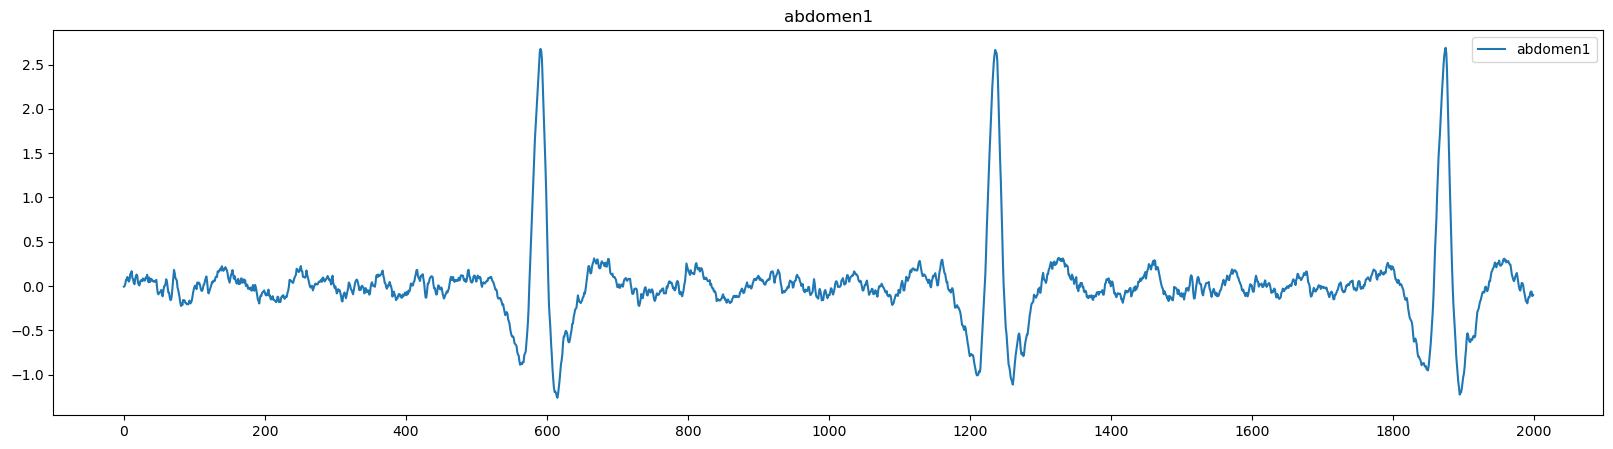

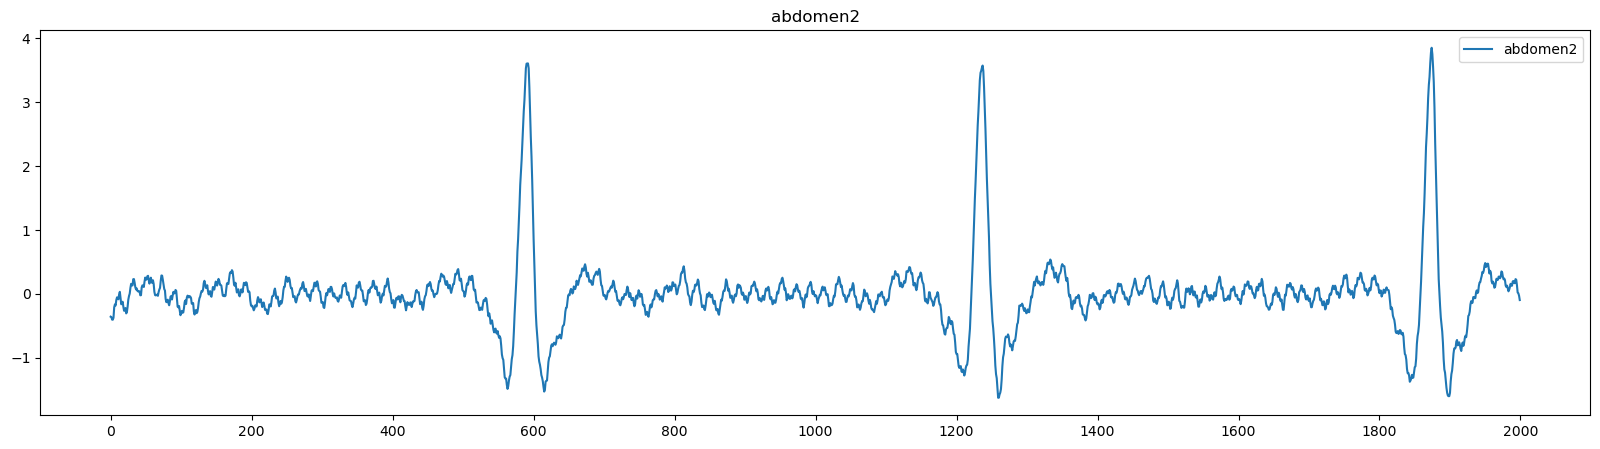

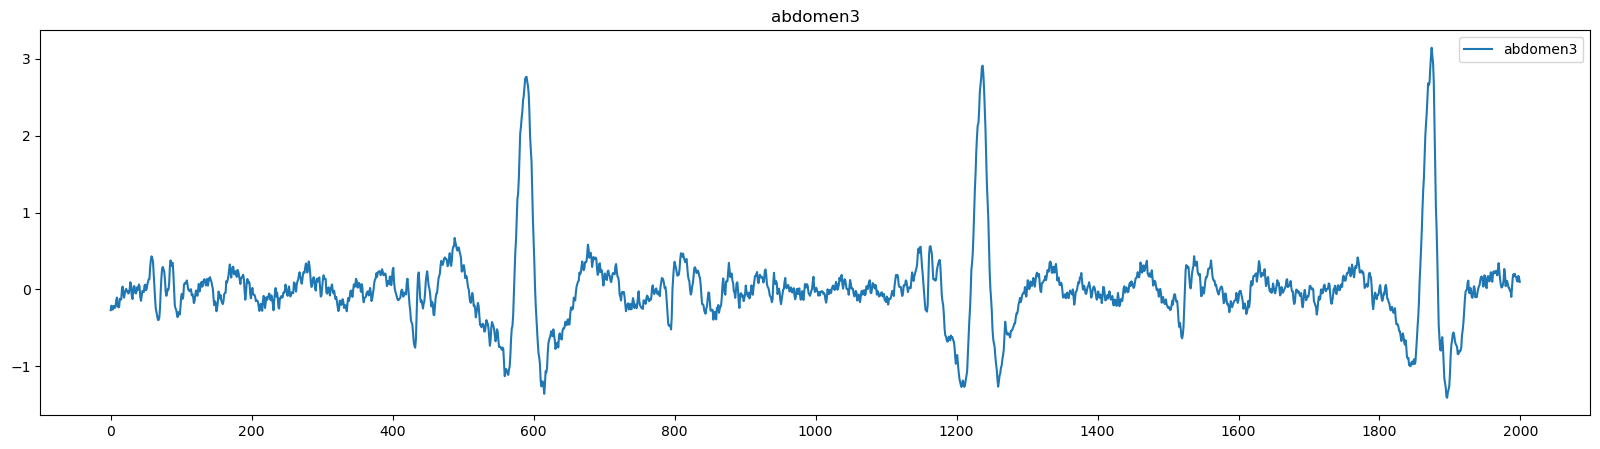

In [288]:
# High pass filter to remove baseline wander
cutoff_baseline_thorax = 0.5
cutoff_baseline_abdomen = 8
fs = 1000


thorax1 = highpass_filter(thorax1, cutoff_baseline_thorax, fs)
thorax2 = highpass_filter(thorax2, cutoff_baseline_thorax, fs)
abdomen1 = highpass_filter(abdomen1, cutoff_baseline_abdomen, fs)
abdomen2 = highpass_filter(abdomen2, cutoff_baseline_abdomen, fs)
abdomen3 = highpass_filter(abdomen3, cutoff_baseline_abdomen, fs)

# plot_signal(thorax1, 'thorax1')
# plot_signal(thorax2, 'thorax2')
plot_signal(abdomen1, 'abdomen1')
plot_signal(abdomen2, 'abdomen2')
plot_signal(abdomen3, 'abdomen3')


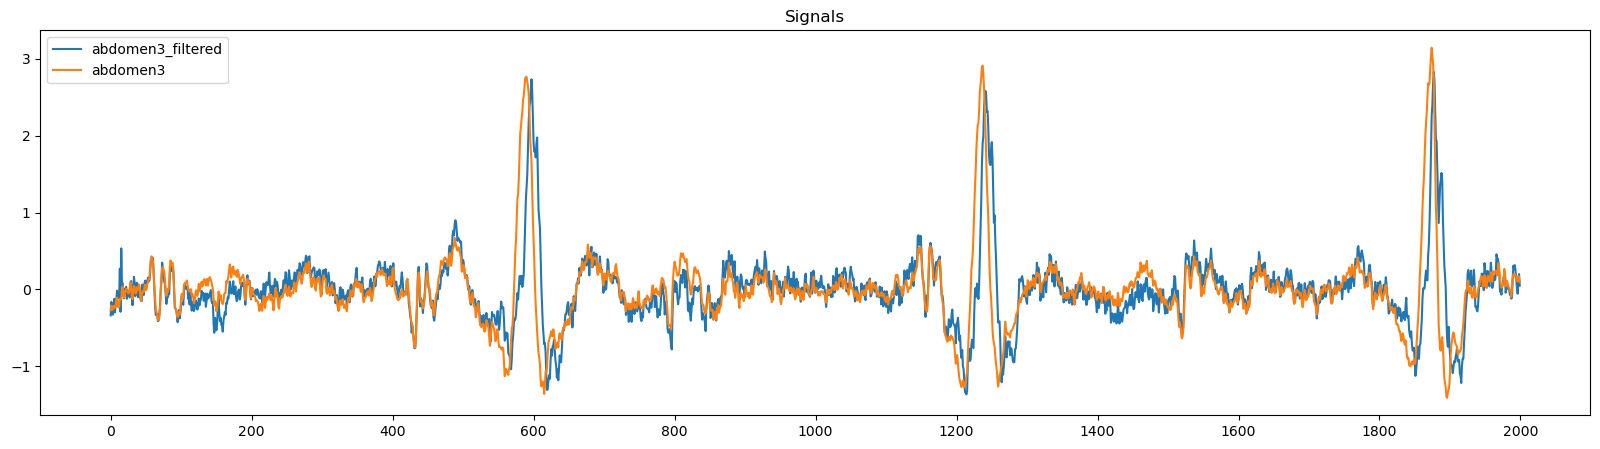

In [289]:
import numpy as np

def non_adaptive_filter(primary, reference, filter_order=1):
    """
    Non-Adaptive Filter for Noise Cancellation
    Args:
        primary: Primary signal (mother + fetal heartbeat from abdomen)
        reference: Noise reference signal (mother's heartbeat from thorax)
        filter_order: Number of filter coefficients
    Returns:
        output: Signal with maternal heartbeat removed
    """
    N = len(primary)
    if len(reference) != N:
        raise ValueError("Primary and reference signals must have the same length.")

    # Construct the reference signal matrix
    X = np.zeros((N - filter_order, filter_order))
    for i in range(filter_order, N):
        X[i - filter_order] = reference[i - filter_order:i]

    # Target vector (primary signal after the initial transient period)
    d = primary[filter_order:]

    # Compute the optimal filter coefficients using least squares
    w = np.linalg.pinv(X) @ d  # Pseudoinverse for optimal coefficients

    # Apply the filter to the reference signal
    y = np.convolve(reference, w, mode='same')

    # Compute the error signal (filtered output)
    output = primary - y

    return output

# Apply the non-adaptive filter to remove maternal heartbeat from abdomen3 signal
filter_order = 32
abdomen3_filtered = non_adaptive_filter(abdomen3, thorax1, filter_order=filter_order)


plot_signals([abdomen3_filtered, abdomen3], ['abdomen3_filtered', 'abdomen3'])
